# Multiclass classification
In this notebook we will make a balance multiclass classification, the starting paper is as follows: [A Deep Learning Approach for Viral DNA Sequence Classification using Genetic Algorithm](https://www.researchgate.net/publication/363276607_A_Deep_Learning_Approach_for_Viral_DNA_Sequence_Classification_using_Genetic_Algorithm)

We will propose different models for the task on a different dataset


#### Definition of common import and functions


In [1]:
import json, os
import pandas as pd
import numpy as np

import keras

from keras.src.losses import SparseCategoricalCrossentropy
from keras.src.optimizers import Adamax, LossScaleOptimizer

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

df_path = './Dataset/MulticlassDatasets/'
df_saved = './Saved/'
epochs = 20
sequence_df = None

## Models

In [2]:
def get_model(dim, num_classes):
    inputs = keras.layers.Input(shape=dim)
    x = keras.layers.Masking(mask_value=-1.0)(inputs)
    x = keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.LSTM(768)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.Dense(256, kernel_regularizer='l2')(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs=inputs, outputs=x)
    return model


### Balanced data set loading

In [3]:
df = None
with open(df_path+'BalancedDataset.jsonl') as f:
  for index, line in tqdm(enumerate(f)):
      data = json.loads(line)
      if df is None:
          df = pd.DataFrame(data=data, index=[0])
      else:
          df.loc[len(df)] = data
df.head()

0it [00:00, ?it/s]

,Accession,Release Date,Species,Genus,Molecule Type,Length,Sequence Type,Host,Collection Date,Sequence,Family
0,OQ599922.1,2023-06-20T00:00:00Z,Banfec circovirus 1,Circovirus,ssDNA(+/-),1680,GenBank,Canis latrans,2021-04-24,TATTACCGGAGACTTTGGAACCGTGGAACAGGCCGATCTGTAATGA...,Circoviridae
1,OQ599923.1,2023-06-20T00:00:00Z,Banfec circovirus 1,Circovirus,ssDNA(+/-),1680,GenBank,Canis latrans,2021-04-23,TATTACCGGAGACTTTGGAACCGTGGAACAGGCCGATCTGTAATGA...,Circoviridae
2,OQ599924.1,2023-06-20T00:00:00Z,Banfec circovirus 2,Circovirus,ssDNA(+/-),2079,GenBank,Canis latrans,2021-04-23,TAGTATTACCCGGCACCTTGACACAGACACTTCGACACACTGCTGC...,Circoviridae
3,OQ241209.1,2023-06-19T00:00:00Z,Circovirus porcine2,Circovirus,ssDNA(+/-),1768,GenBank,Sus scrofa,2021,ACCAGCGCACTTCGGCAGCGGCAGCACCTCGGCAGCACCTCGGCAG...,Circoviridae
4,OQ241210.1,2023-06-19T00:00:00Z,Circovirus porcine2,Circovirus,ssDNA(+/-),1767,GenBank,Sus scrofa,2021,ACCAGCGCACTTCGGCAGCGGCAGCACCTCGGCAGCACCTCAGCAG...,Circoviridae


In [4]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Accession,Release Date,Species,Genus,Molecule Type,Length,Sequence Type,Host,Collection Date,Sequence,Family
0,KP313758.1,2015-06-01T00:00:00Z,Mungbean yellow mosaic India virus,Begomovirus,ssDNA(+/-),2746,GenBank,Vigna radiata,2014-03-01,ACCTGAGTGCCCCGCAACCGGTGTATTGGGGTTACTTTAACTTTTA...,Geminiviridae
1,KJ174938.1,2014-02-17T00:00:00Z,Alphainfluenzavirus influenzae,Alphainfluenzavirus,ssRNA(-),1497,GenBank,Gallus gallus,2013-07-04,ATGGCGTCTCAAGGCACCAAACGATCCTATGAACAGATGGAAACTA...,Orthomyxoviridae
2,KJ887790.1,2014-09-24T00:00:00Z,African cassava mosaic virus,Begomovirus,ssDNA(+/-),2781,GenBank,Manihot esculenta,2007-08-24,ACCGGTTGGCCCCGCCCCCCTTTAAACGTGGTCCCCGCGCACTACG...,Geminiviridae
3,MN100029.1,2020-02-10T00:00:00Z,Opuntia virus 1,Opunvirus,ssDNA(+/-),2940,GenBank,Coccoidea,2017,TAATATTACCTGATGGCCGCGCCCCTTTTGAAGTGGGCCCCAGTAC...,Geminiviridae
4,HF968641.1,2013-10-11T00:00:00Z,Wheat dwarf virus,Mastrevirus,ssDNA(+/-),2740,GenBank,Hordeum vulgare,2012-09,ACCCTGCGTGGTGGGTCCCGAGGCGCACTCGGCTTTTCGTGAGTGC...,Geminiviridae


In [5]:
labels = df['Family']
X = df['Sequence']
X

0        ACCTGAGTGCCCCGCAACCGGTGTATTGGGGTTACTTTAACTTTTA...
1        ATGGCGTCTCAAGGCACCAAACGATCCTATGAACAGATGGAAACTA...
2        ACCGGTTGGCCCCGCCCCCCTTTAAACGTGGTCCCCGCGCACTACG...
3        TAATATTACCTGATGGCCGCGCCCCTTTTGAAGTGGGCCCCAGTAC...
4        ACCCTGCGTGGTGGGTCCCGAGGCGCACTCGGCTTTTCGTGAGTGC...
                               ...                        
60727    ACCAGCGCACTTCGGCAGCGGCAGCACCTCGGCAGCACCTCAGCAG...
60728    AGCAAAAGCAGGGTAGATAATCACTCACTGAGTGACATCAACATCA...
60729    ACCCGCCGCCTGGGGCACCGGGGCACCGCAGCCATTGGCTGCCTTG...
60730    ATGGCGTCTCAAGGCACCAAACGATCATATGAACAAATGGAGACTG...
60731    ACCTGAGTGCCCCGCGACCGGTGTATCGGTTTTAGAGCACGTGGGT...
Name: Sequence, Length: 60732, dtype: object

I see the maximum length of the sequence so that I can make the dataset containing sequence and target

In [6]:
max_len = []
for el in X:
    max_len.append(len(el))
max_len = max(max_len)
max_len

3999

In [7]:
cols =[]

for col in range(max_len):
    cols.append('nucleotide_' + str(col))


In [8]:
def encoder_sequence(seq):
  if seq == 'A':
    return 1
  elif seq == 'C':
    return 2
  elif seq == 'G':
    return 3
  elif seq == 'T':
    return 4
  else:
    return -1

def decode_sequence(seq):
  if seq == 1:
    return 'A'
  elif seq == 2:
    return 'C'
  elif seq == 3:
    return 'G'
  elif seq == 4:
    return 'T'
  else:
    return None

In [9]:
sequence_df = pd.DataFrame(columns = cols)

for row in tqdm(X):
    sequence = {}
    row = list(row)
    for index, i in enumerate(cols):
        if index < len(row):
            sequence[i] = encoder_sequence(row[index])
        else:
          sequence[i] = None

    sequence_df.loc[len(sequence_df)] = sequence

sequence_df.head()

  0%|          | 0/60732 [00:00<?, ?it/s]

,nucleotide_0,nucleotide_1,nucleotide_2,nucleotide_3,nucleotide_4,nucleotide_5,nucleotide_6,nucleotide_7,nucleotide_8,nucleotide_9,...,nucleotide_3989,nucleotide_3990,nucleotide_3991,nucleotide_3992,nucleotide_3993,nucleotide_3994,nucleotide_3995,nucleotide_3996,nucleotide_3997,nucleotide_3998
0,1,2,2,4,3,1,3,4,3,2,...,None,None,None,None,None,None,None,None,None,None
1,1,4,3,3,2,3,4,2,4,2,...,None,None,None,None,None,None,None,None,None,None
2,1,2,2,3,3,4,4,3,3,2,...,None,None,None,None,None,None,None,None,None,None
3,4,1,1,4,1,4,4,1,2,2,...,None,None,None,None,None,None,None,None,None,None
4,1,2,2,2,4,3,2,3,4,3,...,None,None,None,None,None,None,None,None,None,None


In [10]:
sequence_df['Target'] = labels
sequence_df.head()
sequence_df.to_json(df_path+'ProcessedBalancedDataset.jsonl', orient='records', lines=True)

C:\Users\micco\AppData\Local\Temp\ipykernel_22532\3117145268.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sequence_df['Target'] = labels


In [27]:
# If all previous step are performed, skip to this cell
if os.path.exists(df_path+'ProcessedBalancedDataset.jsonl') and sequence_df is None:
    print('Loading data from ProcessedBalancedDataset.jsonl...')
    sequence_df = pd.read_json(df_path+'ProcessedBalancedDataset.jsonl', orient='records', lines=True)
else:
    print('Dataset or dataset already created not exists, run previous step.')

sequence_df = sequence_df.sample(frac=1).reset_index(drop=True)
labels = sequence_df['Target']
X = sequence_df.drop(['Target'], axis=1)
X.head()

Dataset or dataset already created not exists, run previous step.


,nucleotide_0,nucleotide_1,nucleotide_2,nucleotide_3,nucleotide_4,nucleotide_5,nucleotide_6,nucleotide_7,nucleotide_8,nucleotide_9,...,nucleotide_3989,nucleotide_3990,nucleotide_3991,nucleotide_3992,nucleotide_3993,nucleotide_3994,nucleotide_3995,nucleotide_3996,nucleotide_3997,nucleotide_3998
0,1,4,3,1,1,1,4,2,1,4,...,None,None,None,None,None,None,None,None,None,None
1,1,4,3,4,2,4,3,1,4,2,...,None,None,None,None,None,None,None,None,None,None
2,1,2,2,3,3,4,4,3,3,2,...,None,None,None,None,None,None,None,None,None,None
3,1,2,2,3,3,1,4,3,3,2,...,None,None,None,None,None,None,None,None,None,None
4,1,4,3,3,1,2,4,2,2,1,...,None,None,None,None,None,None,None,None,None,None


In [28]:
labels.value_counts()

Target
Circoviridae        15183
Geminiviridae       15183
Orthomyxoviridae    15183
Hepadnaviridae      15183
Name: count, dtype: int64

## Prepare last preprocessing steps

In [29]:
encoder_y = LabelEncoder()
scaler = MinMaxScaler()
X = X.to_numpy().astype(np.float32)
y = labels.to_numpy()

# fit the encoder for the label
encoder_y.fit(y)
# scaling the feature
X = scaler.fit_transform(X)

X.shape, y.shape

((60732, 3999), (60732,))

In [30]:
dimension = (X.shape[1], 1)
dimension

(3999, 1)

In [31]:
n_class = len(labels.unique())
# param for the model
batch_size = 32
n_class

4

In [32]:
model = get_model(dimension, n_class)
model.compile(
    optimizer=LossScaleOptimizer(
        Adamax(
        learning_rate=0.002,
        )
    ),
    loss=SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

D:\Vito\ML\venv\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3999, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking_1 (Masking)             │ (None, 3999, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3995, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1997, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1993, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 996, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 768)            │     2,755,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,998,020 (11.44 MB)

 Trainable params: 2,996,484 (11.43 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Continual learning
For fit the model we suse the technique of continual learning, so we split the dataset into n batch and 
we fit the model for every batch saving the most performant model.

In [33]:
n_batch = 10
start = 0
step = int(len(X)/n_batch) 
end = step

all_df = []

for i in range(n_batch):
    all_df.append(
        {
            'X': X[start:end],
            'y': y[start:end]
        }
    )
    start += step
    end += step

step, end

(6073, 66803)

In [ ]:
best_accuracy = 0
# best model to save
best_model = None

# metrics of the best classification for the evaluation of the best model
best_pred = None
gt_pred = None

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1,
    verbose=1,
    mode="auto",
    start_from_epoch=0,
)

all_accuracy = []
all_loss = []
for df in all_df:
    X_f, X_test, y_f, y_test = train_test_split(df['X'], df['y'], test_size=0.2, random_state=42)
    
    X_train, X_val, y_train, y_val = train_test_split(X_f, y_f, test_size=0.1, random_state=42)
    
    X_train = np.nan_to_num(X_train, nan=-1.0)
    X_val = np.nan_to_num(X_val, nan=-1.0)
    X_test = np.nan_to_num(X_test, nan=-1.0)
    
    # reshape for three-dimensional space
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    y_train = encoder_y.transform(y_train).astype(np.float32)
    y_val = encoder_y.transform(y_val).astype(np.float32)
    y_test = encoder_y.transform(y_test).astype(np.float32)
    

    # fit the model
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping],
    )

    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    
    all_accuracy.append(acc)
    all_loss.append(loss)
    # get the prediction        
    y_pred = model.predict(X_test, verbose=0)
    y_pred = [np.argmax(y) for y in y_pred]
    y_pred = encoder_y.inverse_transform(y_pred)
    
    if acc > best_accuracy:
        print(f'Saving best model with Accuracy of {acc*100:.2f}%...')
        best_accuracy = acc
        best_model = model
        best_pred = y_pred
        gt_pred = y_test
    
# plot the fit metrics
fig, axes = plt.subplots(
                     ncols=2,
                     nrows=1,
)

ax1, ax2 = axes.flatten()
# summarize history for accuracy
ax1.plot(all_accuracy)
ax1.legend(['test'])
ax1.set_title('Accuracy')
ax2.plot(all_loss)
ax2.legend(['test'])
ax2.set_title('Loss')
fig.suptitle(f'Accuracy Stratified K fold')
fig.show()

In [42]:
best_model =keras.models.load_model(df_saved+'BestBalancedModelContinualLearningOverfitted.keras')

D:\Vito\ML\venv\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [43]:
sequence_df['Target'] = labels
test = pd.concat([
    sequence_df[sequence_df['Target'] == 'Geminiviridae'][:100],
    sequence_df[sequence_df['Target'] == 'Hepadnaviridae'][:100],
    sequence_df[sequence_df['Target'] == 'Orthomyxoviridae'][:100],
    sequence_df[sequence_df['Target'] == 'Circoviridae'][:100]
])

print(test.shape)

test = test.sample(frac=1).reset_index(drop=True)
y_test = test['Target'].to_numpy()
X = test.drop(['Target'],axis=1).to_numpy()
X = scaler.transform(X)
X = np.nan_to_num(X, nan=-1.0)
X = X.reshape(X.shape[0], X.shape[1], 1)

y_pred = best_model.predict(X, verbose=1)
y_pred = [np.argmax(y) for y in y_pred]
y_pred = encoder_y.inverse_transform(y_pred)

(400, 4000)


D:\Vito\ML\venv\Lib\site-packages\keras\src\layers\layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


In [44]:
print(classification_report(y_true=y_test, y_pred=y_pred, zero_division=0))

                  precision    recall  f1-score   support

    Circoviridae       0.00      0.00      0.00       100
   Geminiviridae       0.25      1.00      0.40       100
  Hepadnaviridae       0.00      0.00      0.00       100
Orthomyxoviridae       0.00      0.00      0.00       100

        accuracy                           0.25       400
       macro avg       0.06      0.25      0.10       400
    weighted avg       0.06      0.25      0.10       400



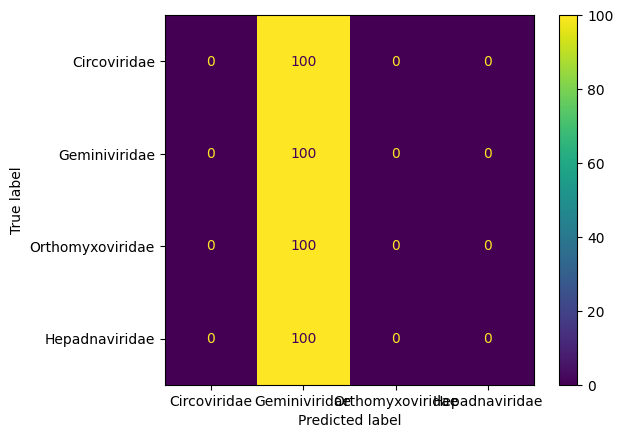

In [45]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels.unique()
)

disp.plot()

In [46]:
# saving the best model
best_model.save(df_saved+'BestBalancedModelContinualLearning.keras')